# Likelihood Ratio Test Application to Wisconsin Cancer Detection Dataset

## Evaluating the influence of a feature on the detection of a malignous vs benign tumor

### Importing data from Kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


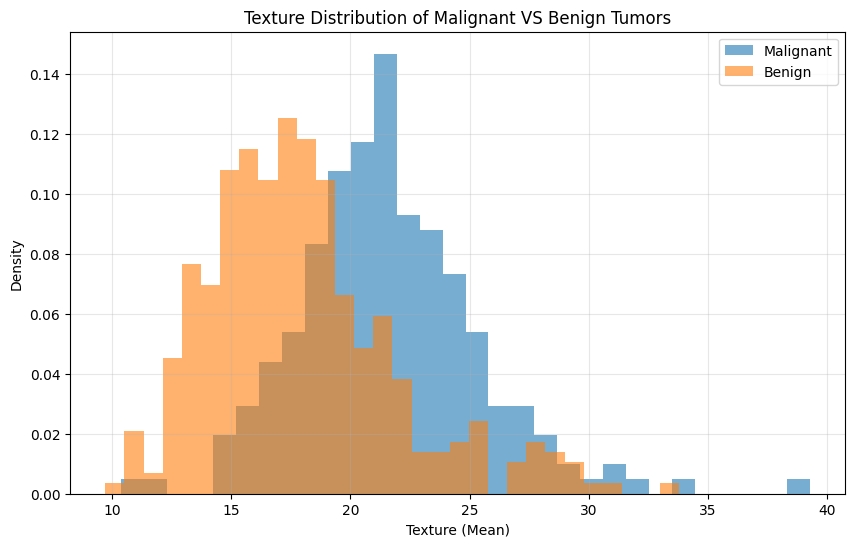

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("/content/drive/My Drive/kaggle/CancerData.csv")
data = data.drop(columns=["id", "Unnamed: 32"])
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

# Extract texture_mean for each group
malignant = data[data["diagnosis"] == 1]["texture_mean"]
benign    = data[data["diagnosis"] == 0]["texture_mean"]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(malignant, bins=30, alpha=0.6, label="Malignant", density=True)
plt.hist(benign, bins=30, alpha=0.6, label="Benign", density=True)

plt.xlabel("Texture (Mean)")
plt.ylabel("Density")
plt.title("Texture Distribution of Malignant VS Benign Tumors")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv("/content/drive/My Drive/kaggle/CancerData.csv")
data = data.drop(columns=["id", "Unnamed: 32"])
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

y = data["diagnosis"] # target M = Malignous B = Benign
X = data.drop(columns=["diagnosis"]) # features

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### Removing highly correlated predictors using VIF

In [12]:
def compute_vif(df):
    """Returns a DataFrame with VIF for each column."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["vif"] = [
        variance_inflation_factor(df.values, i)
        for i in range(df.shape[1])
    ]
    return vif_data

X_clean = X_scaled.copy()

while True:
    vif_table = compute_vif(X_clean)
    max_vif = vif_table["vif"].max()
    worst_feature = vif_table.loc[vif_table["vif"].idxmax(), "feature"]

    if max_vif > 10:
        print(f"Removing '{worst_feature}' (VIF = {max_vif:.2f})")
        X_clean = X_clean.drop(columns=[worst_feature])
    else:
        break

print("\nRemaining variables after VIF cleaning:")
print(list(X_clean.columns))

Removing 'radius_mean' (VIF = 3806.12)
Removing 'radius_worst' (VIF = 616.35)
Removing 'perimeter_mean' (VIF = 325.64)
Removing 'perimeter_worst' (VIF = 123.26)
Removing 'concavity_mean' (VIF = 64.65)
Removing 'radius_se' (VIF = 35.62)
Removing 'compactness_worst' (VIF = 33.96)
Removing 'concave points_worst' (VIF = 30.60)
Removing 'area_mean' (VIF = 25.39)
Removing 'compactness_mean' (VIF = 18.84)
Removing 'texture_worst' (VIF = 17.23)
Removing 'area_se' (VIF = 16.33)
Removing 'concavity_worst' (VIF = 15.51)

Remaining variables after VIF cleaning:
['texture_mean', 'smoothness_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'perimeter_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'area_worst', 'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst']


### Testing the relevance influence of texture  

In [13]:
var_to_test = "texture_mean"

### Building Full model and computing $l_1$

In [14]:
X_full = sm.add_constant(X_clean)
full_model = sm.Logit(y, X_full).fit(disp=0)
ll1 = full_model.llf  # Full model log-likelihood


### Building Reduced model and computing $l_0$

In [15]:
X_reduced = sm.add_constant(X_clean.drop(columns=[var_to_test]))
reduced_model = sm.Logit(y, X_reduced).fit(disp=0)
ll0 = reduced_model.llf  # Reduced model log-likelihood

### Running LRT

In [16]:
LR_stat = 2 * (ll1 - ll0)
p_value = 1 - chi2.cdf(LR_stat, df=1)

### Results

In [18]:
print("Variable tested:", var_to_test)
print("Log-likelihood reduced model:", ll0)
print("Log-likelihood full model:    ", ll1)
print("Λ =", LR_stat)
print("p-value =", p_value)

Variable tested: texture_mean
Log-likelihood reduced model: -36.58773116869871
Log-likelihood full model:     -30.19229330604131
Λ = 12.790875725314798
p-value = 0.00034831402938106937


## Iterating for all features :

In [19]:
variables_to_test = [
    'texture_mean', 'smoothness_mean', 'concave points_mean', 'symmetry_mean',
    'fractal_dimension_mean', 'texture_se', 'perimeter_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
    'fractal_dimension_se', 'area_worst', 'smoothness_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

results = []

for var in variables_to_test:
    X_full = sm.add_constant(X_clean)
    X_reduced = sm.add_constant(X_clean.drop(columns=[var]))
    full_model = sm.Logit(y, X_full).fit(disp=0)
    reduced_model = sm.Logit(y, X_reduced).fit(disp=0)
    ll1 = full_model.llf
    ll0 = reduced_model.llf
    LR_stat = 2 * (ll1 - ll0)
    p_value = 1 - chi2.cdf(LR_stat, df=1)
    results.append([var, LR_stat, p_value])

lrt_results = pd.DataFrame(results, columns=["Variable", "LR_stat", "p_value"])
lrt_results = lrt_results.sort_values(by="p_value")

print(lrt_results)
print("\nMost significant variable:", lrt_results.iloc[0]["Variable"])


                   Variable    LR_stat   p_value
13               area_worst  14.513243  0.000139
0              texture_mean  12.790876  0.000348
6              perimeter_se   6.516590  0.010687
2       concave points_mean   4.360784  0.036775
15           symmetry_worst   3.374683  0.066205
12     fractal_dimension_se   3.151676  0.075849
9              concavity_se   3.087708  0.078886
16  fractal_dimension_worst   3.011420  0.082680
8            compactness_se   2.387982  0.122271
5                texture_se   2.039842  0.153226
4    fractal_dimension_mean   1.471296  0.225141
14         smoothness_worst   0.785562  0.375446
7             smoothness_se   0.515885  0.472602
11              symmetry_se   0.494774  0.481805
3             symmetry_mean   0.300467  0.583590
10        concave points_se   0.257145  0.612088
1           smoothness_mean   0.002002  0.964313

Most significant variable: area_worst
